<a href="https://colab.research.google.com/github/Polyneuro/github-starter-course/blob/main/Dirichlet_Genome_ParameterAndPrevalence_Analysis_Final3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Running comprehensive analysis...

Simulating common disorder...


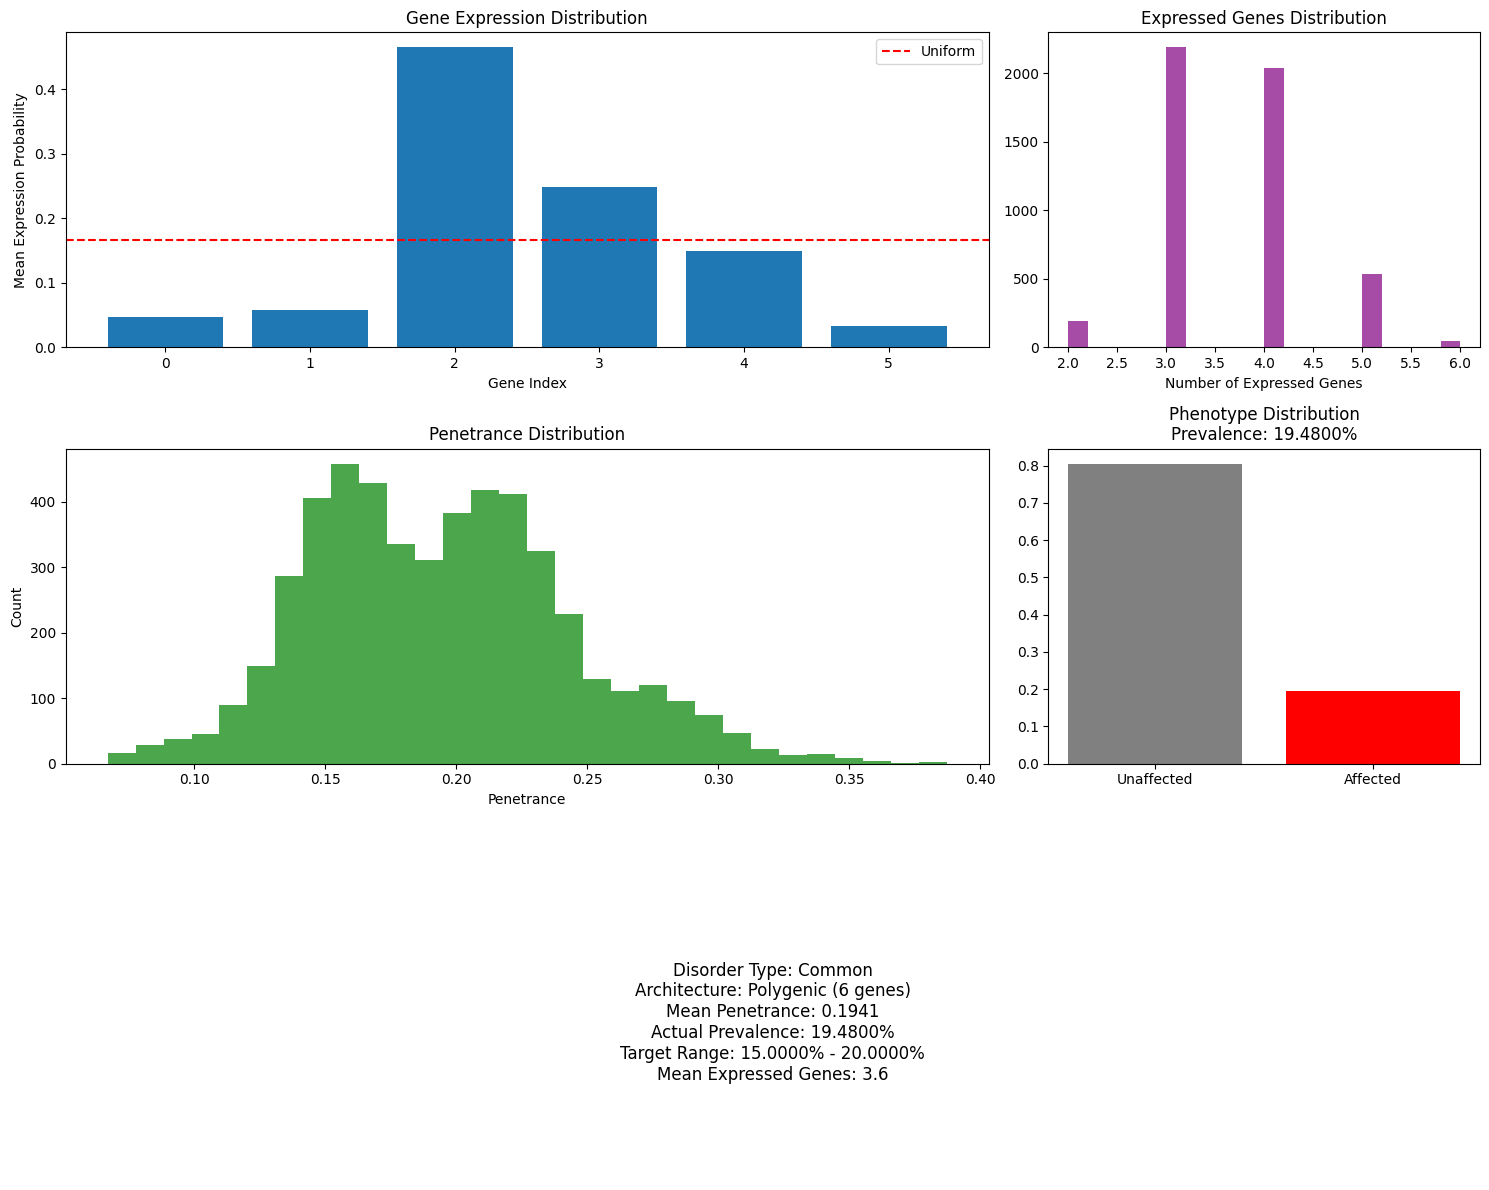

Type: polygenic
Number of genes: 6
Actual prevalence: 0.194800

Simulating moderate disorder...


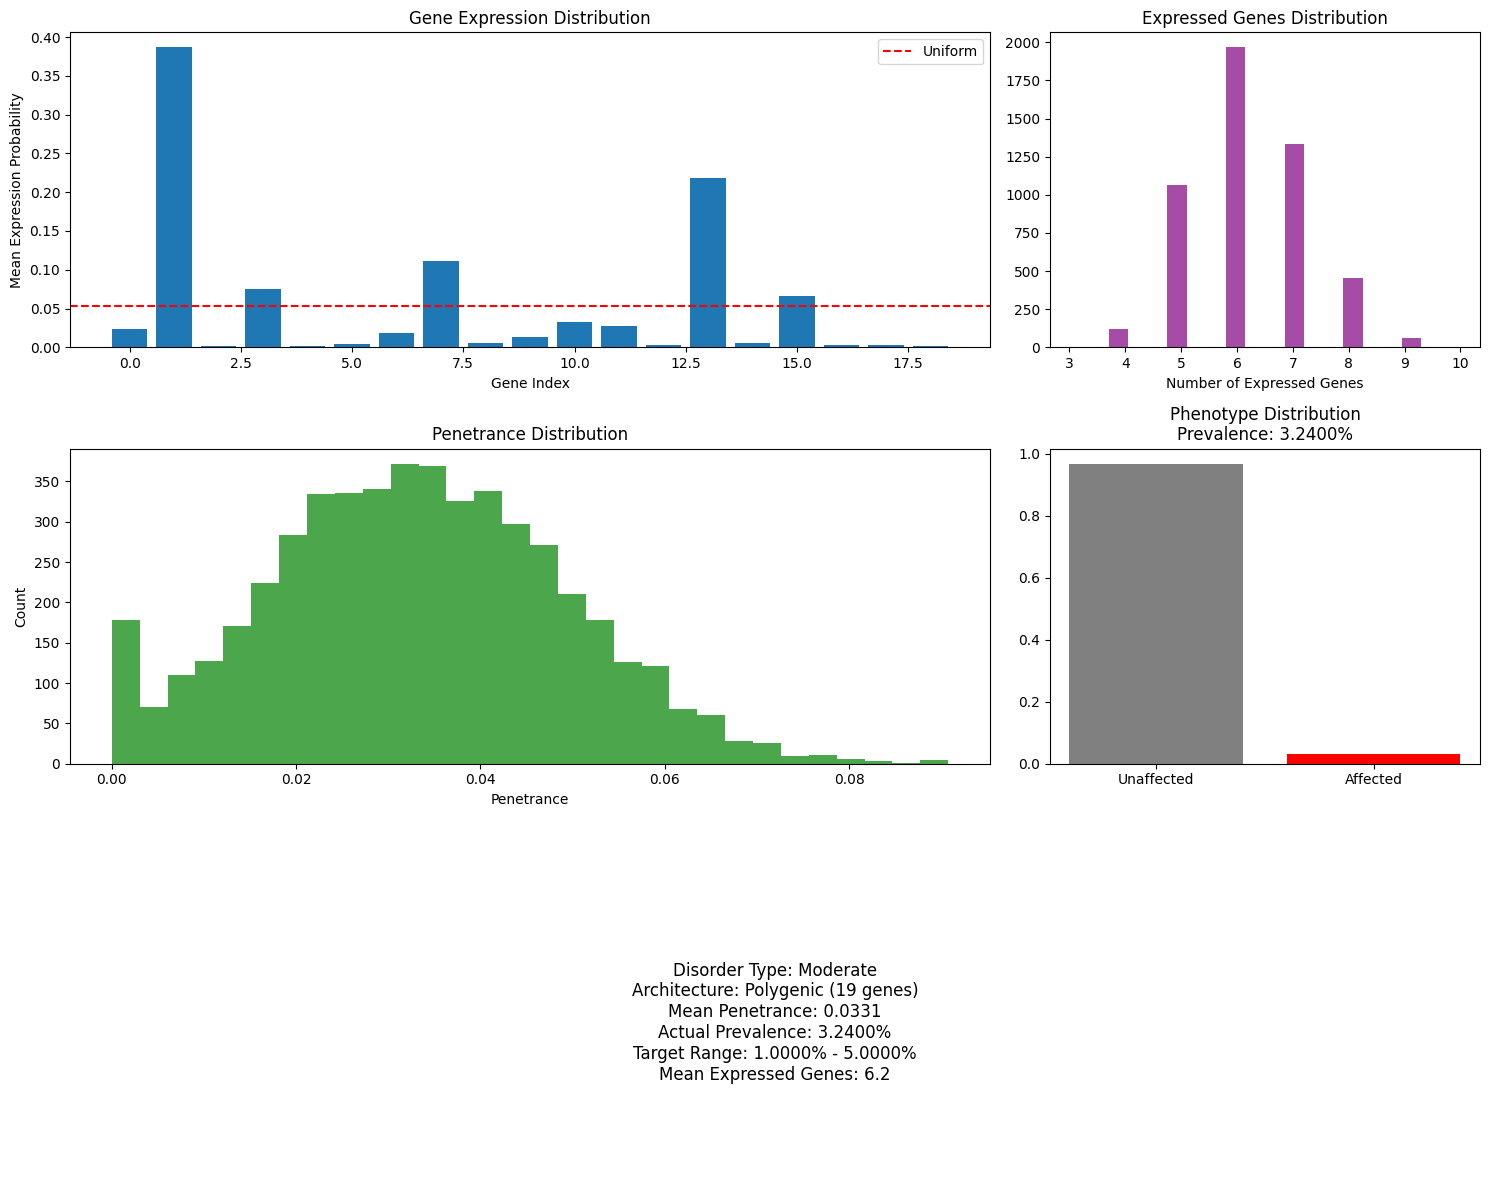

Type: polygenic
Number of genes: 19
Actual prevalence: 0.032400

Simulating rare disorder...


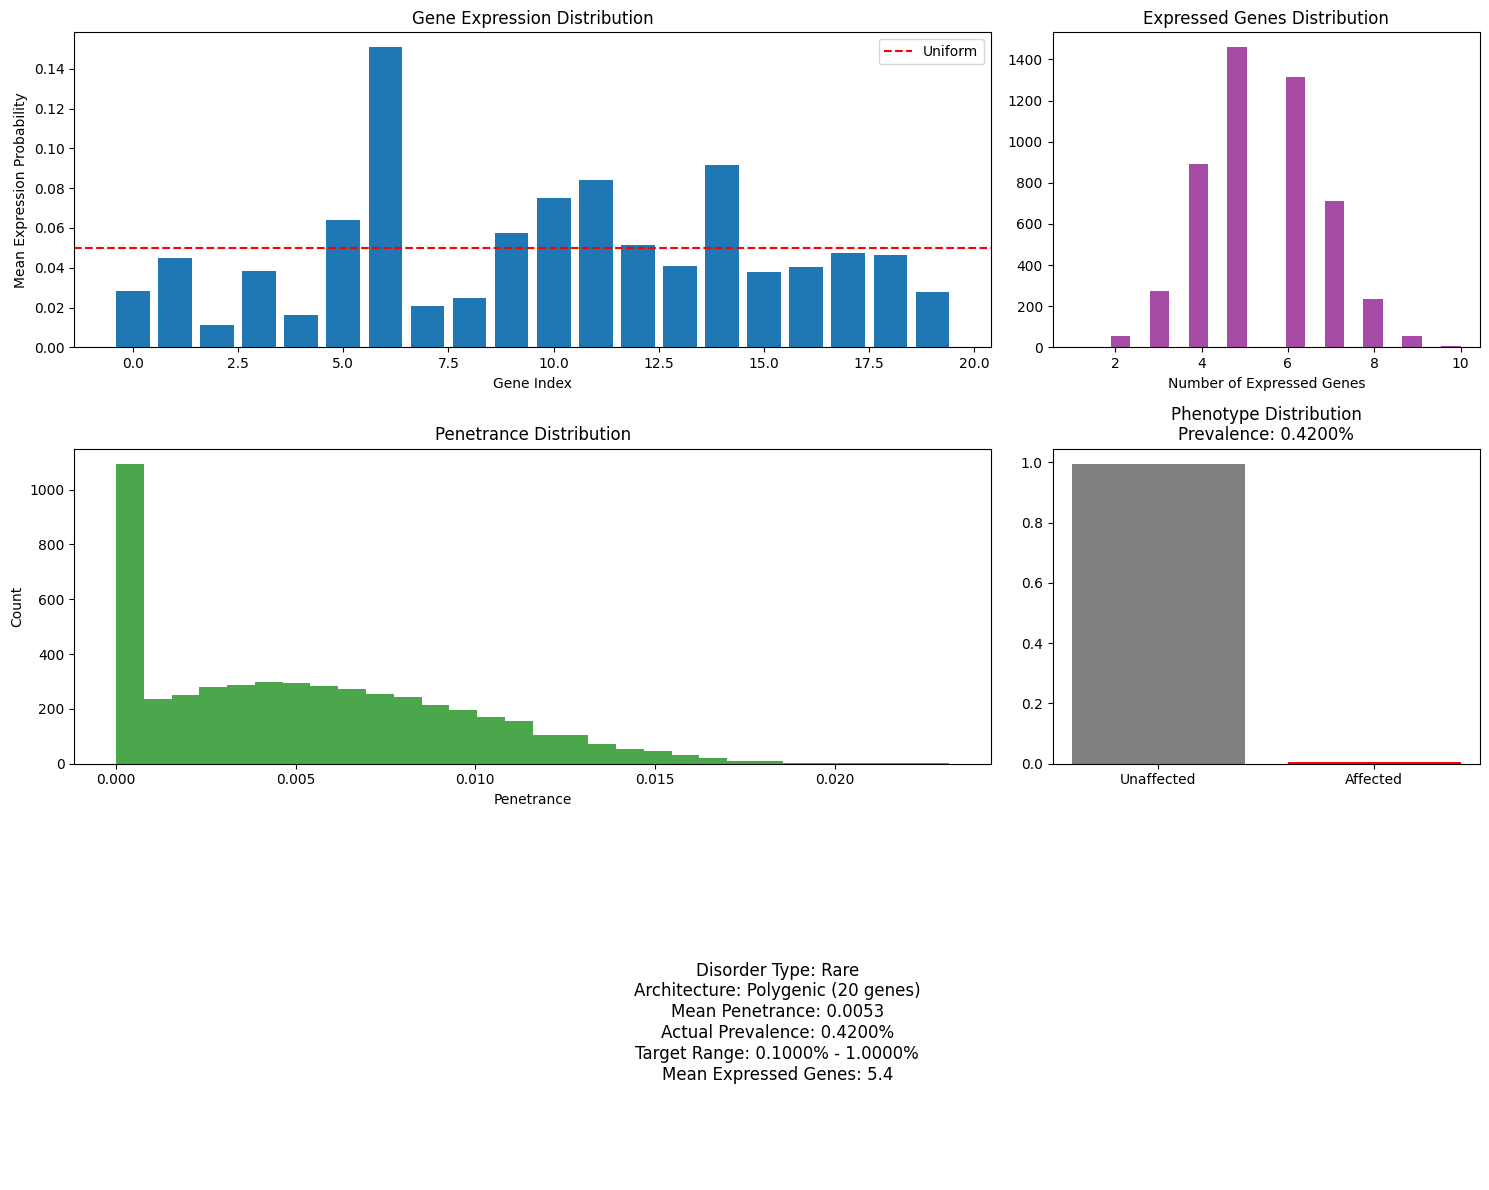

Type: polygenic
Number of genes: 20
Actual prevalence: 0.004200

Simulating ultra_rare disorder...


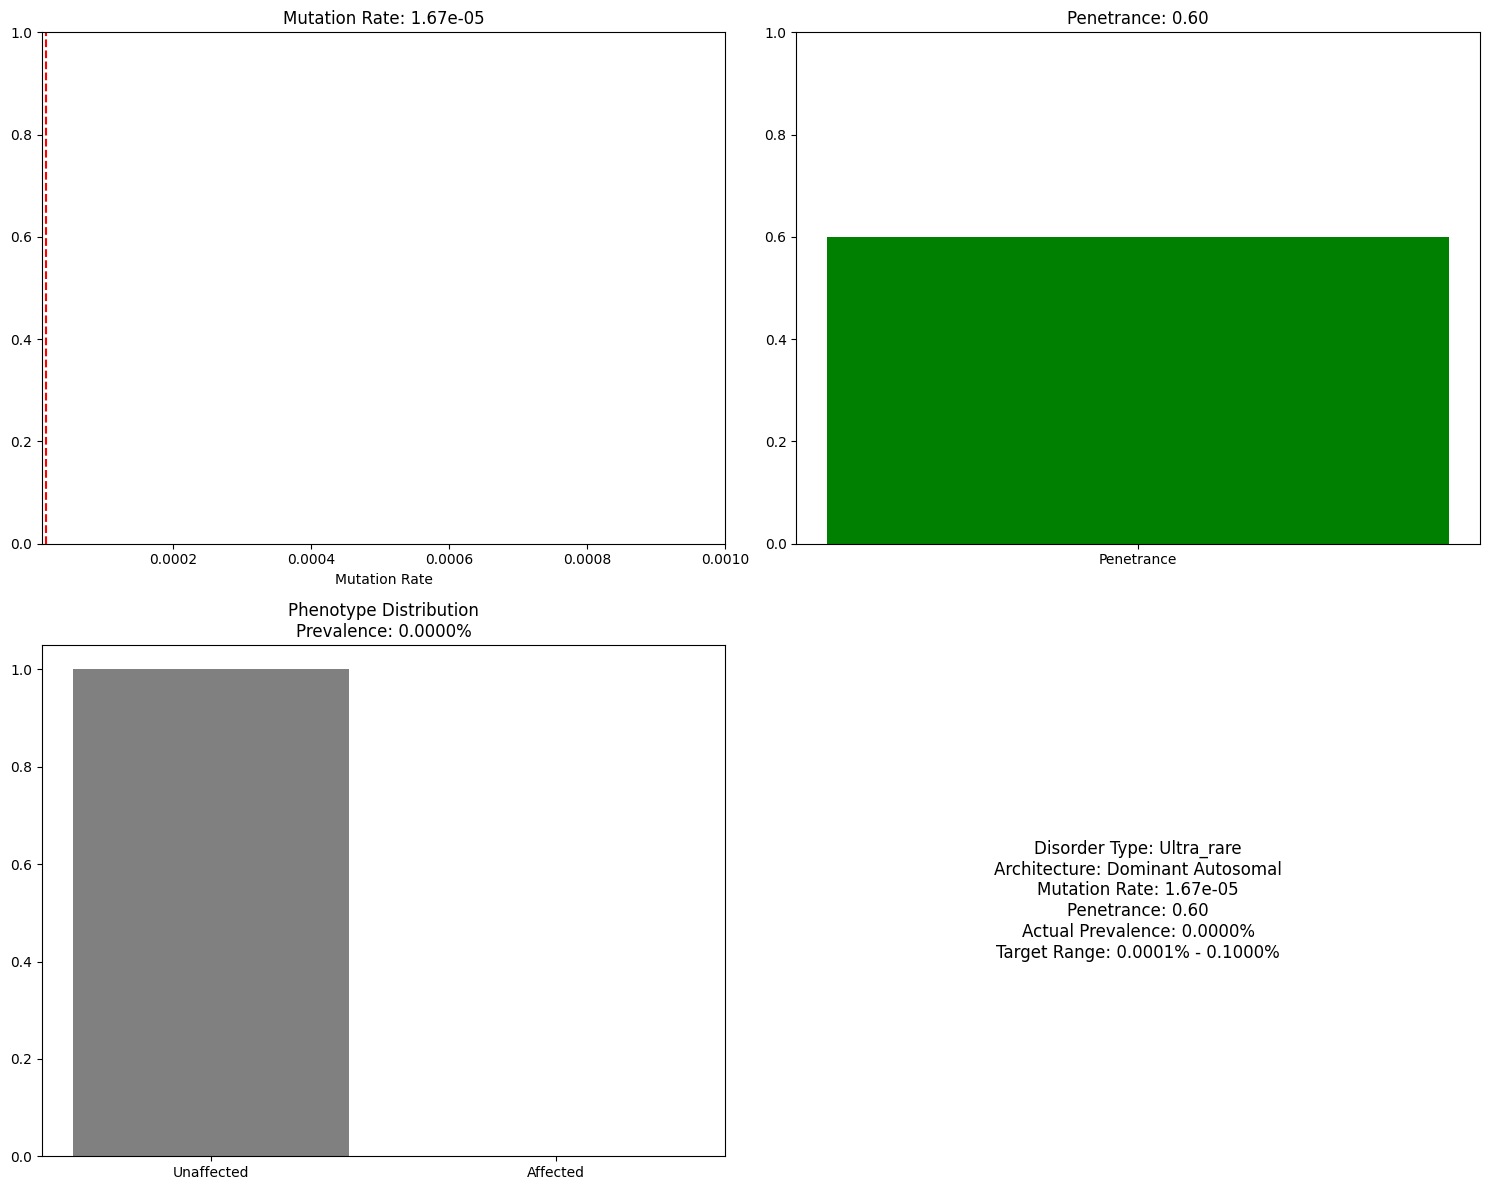

Type: autosomal
Number of genes: 1
Actual prevalence: 0.000000


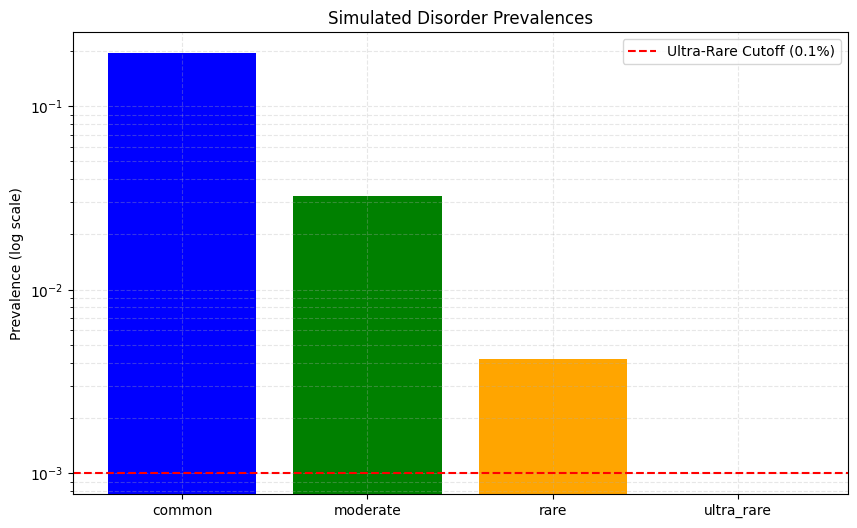


Running batch analysis...


Running batch analysis: 100%|██████████| 50/50 [00:07<00:00,  6.48it/s]
/tmp/ipython-input-26-4250461421.py:317: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=self.prevalence_ranges.keys())
/tmp/ipython-input-26-4250461421.py:325: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=self.prevalence_ranges.keys())


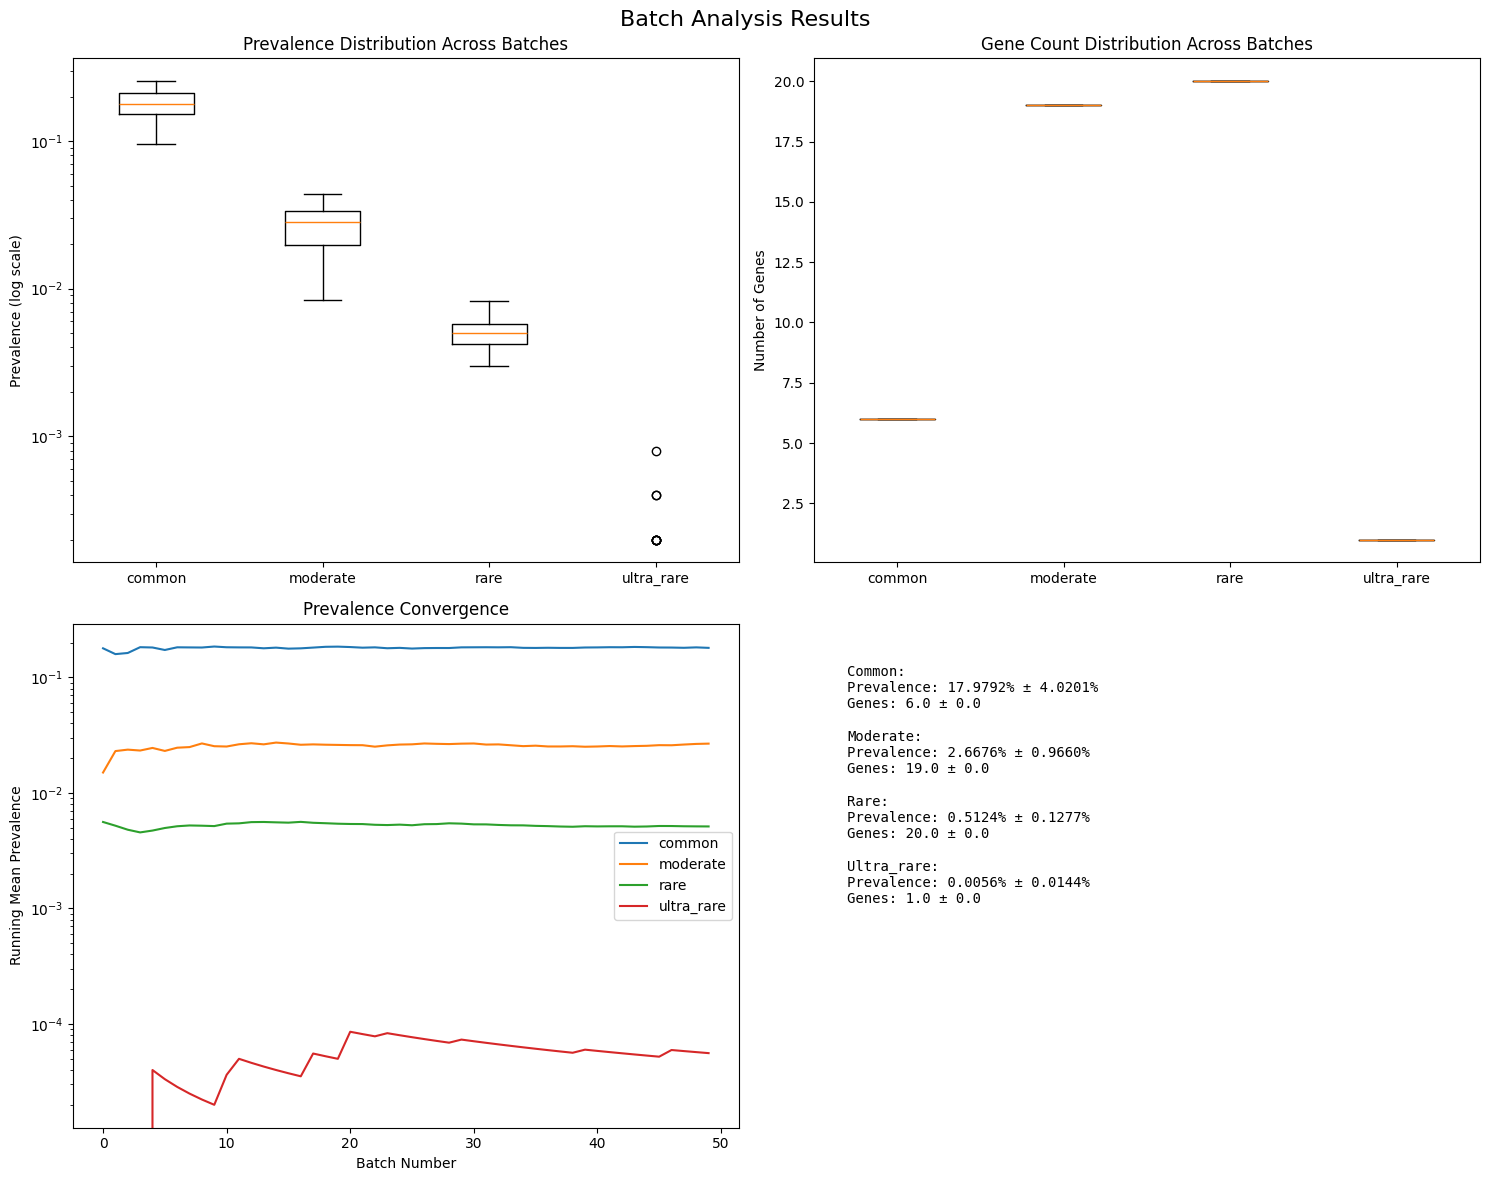


Running sensitivity analysis...


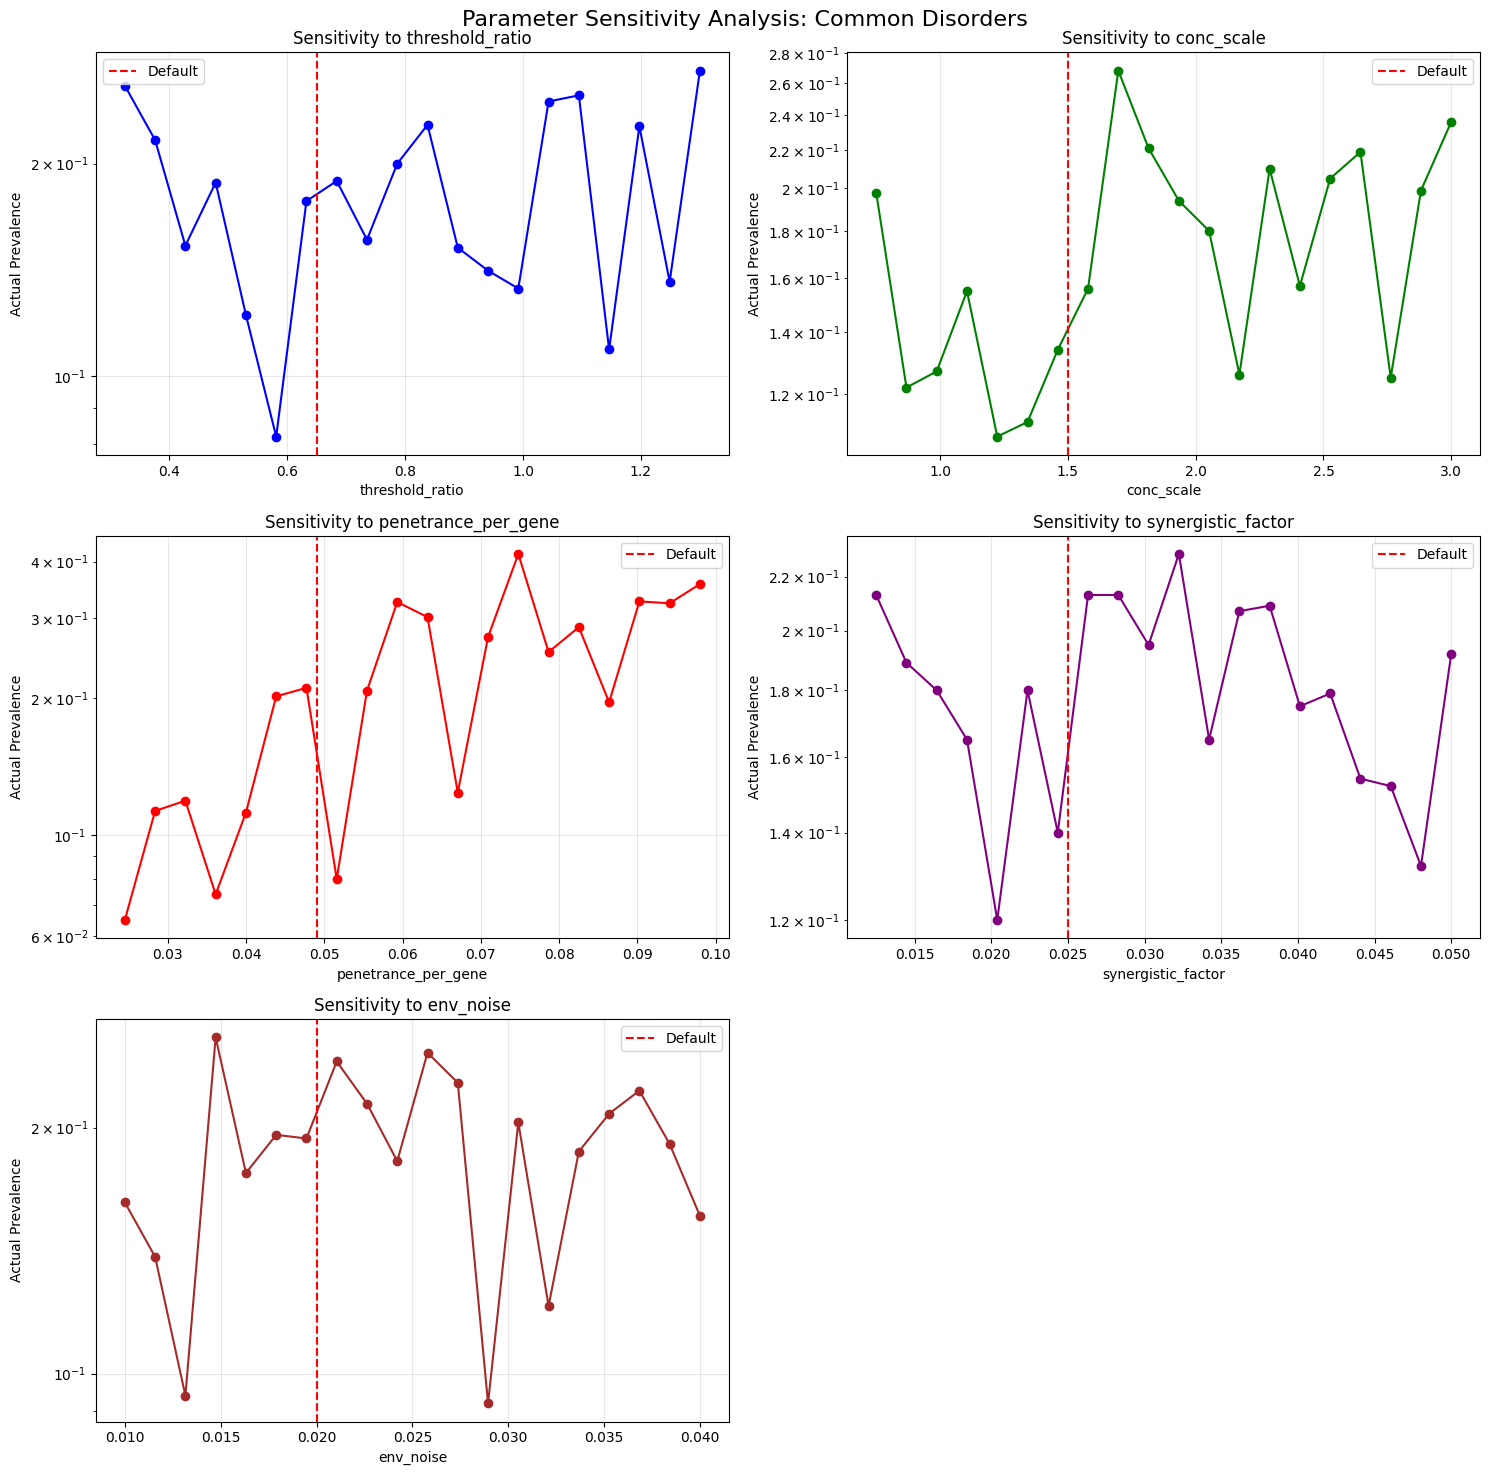

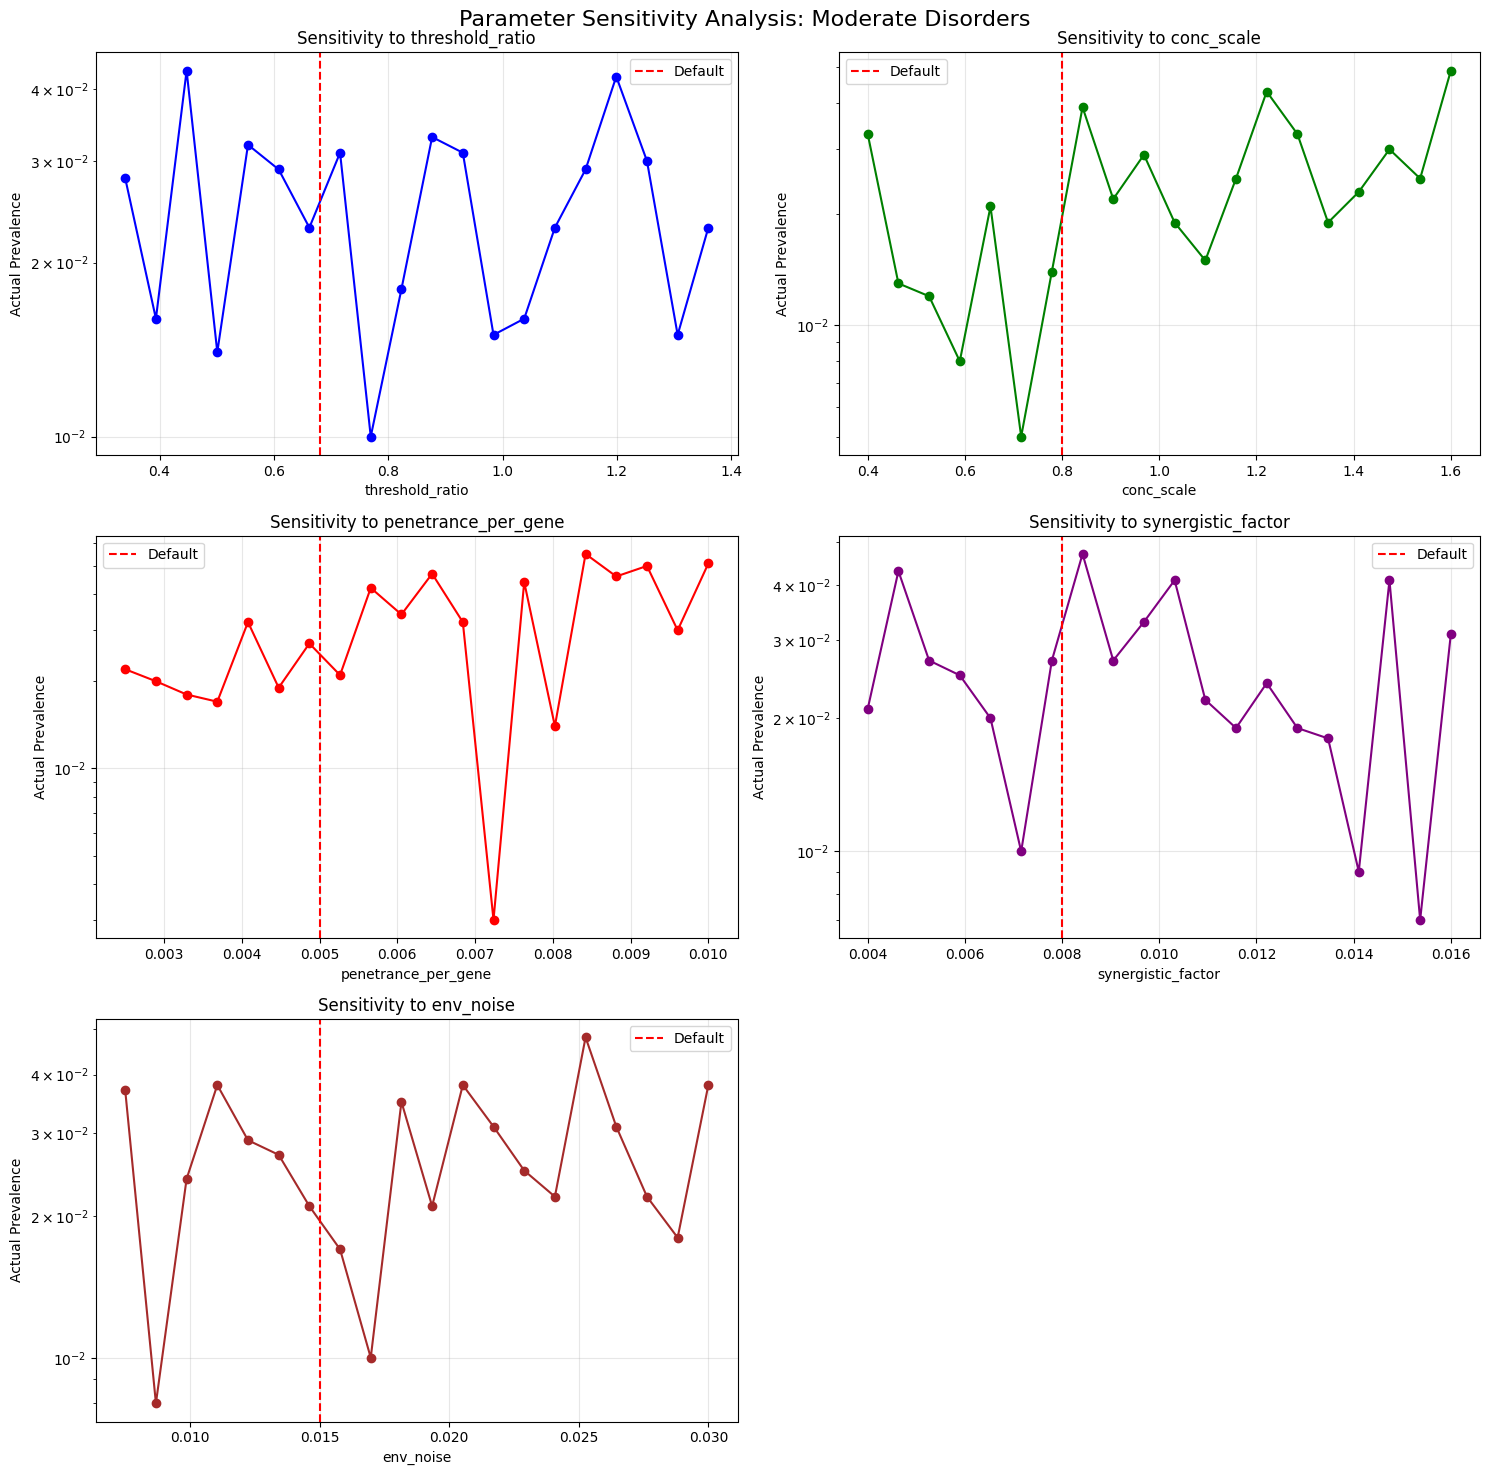

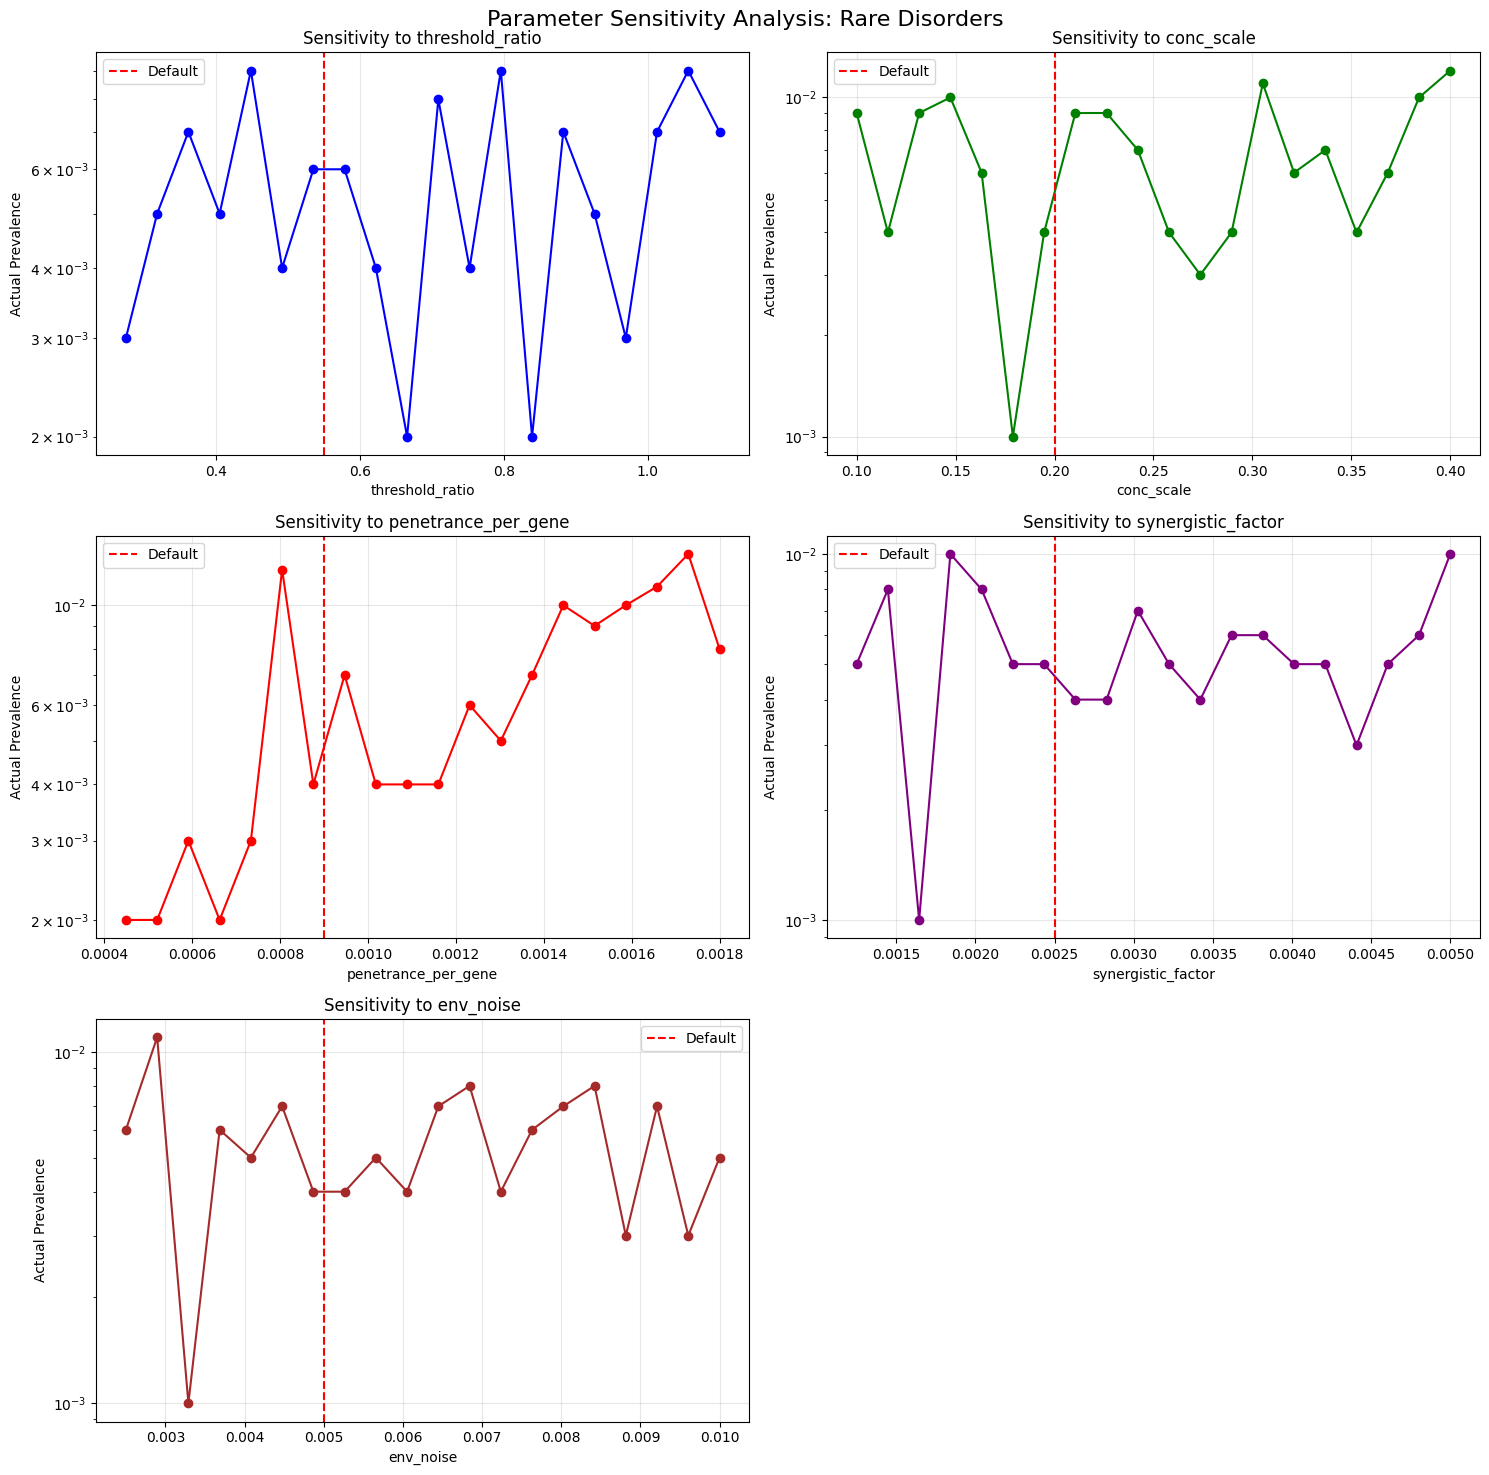


Running prevalence iteration analysis...


Running prevalence iterations: 100%|██████████| 50/50 [00:08<00:00,  6.20it/s]


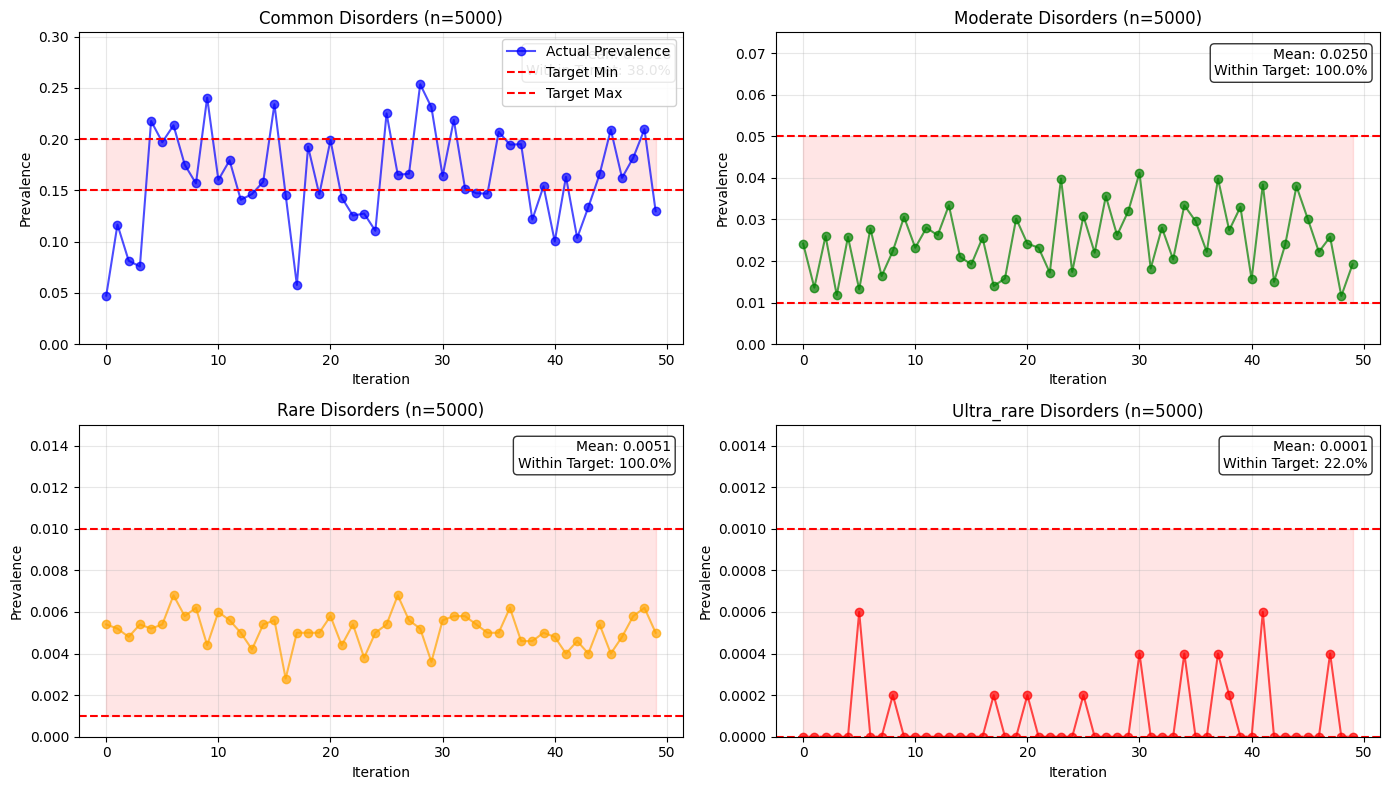


Analysis complete. Check the generated PNG files for visualizations.


In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from scipy.stats import beta
from tqdm import tqdm
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Set default float type to float32 to avoid dtype issues
tf.keras.backend.set_floatx('float32')

tfd = tfp.distributions

class UnifiedGeneticDisorderSimulation:
    def __init__(self):
        # Unified parameter space
        self.prevalence_ranges = {
            'common': (0.15, 0.20),
            'moderate': (0.01, 0.05),
            'rare': (0.001, 0.01),
            'ultra_rare': (1e-6, 0.001)
        }

        # Adjusted core genes based on your calibration
        self.core_genes = {
            'common': (5, 10, 6),
            'moderate': (5, 30, 19),
            'rare': (6, 25, 20)
        }

        # Adjusted network parameters to fix rare/moderate issue
        self.network_params = {
            'common': {
                'threshold_ratio': 0.65,
                'conc_scale': 1.5,
                'penetrance_per_gene': 0.049,
                'synergistic_factor': 0.025,
                'env_noise': 0.02
            },
            'moderate': {
                'threshold_ratio': 0.68,
                'conc_scale': 0.8,
                'penetrance_per_gene': 0.005,
                'synergistic_factor': 0.008,
                'env_noise': 0.015
            },
            'rare': {
                'threshold_ratio': 0.55,
                'conc_scale': 0.2,
                'penetrance_per_gene': 0.0009,
                'synergistic_factor': 0.0025,
                'env_noise': 0.005
            }
        }

        self.autosomal_params = {
            'prevalence_cutoff': 0.001,
            'dominant_penetrance': 0.60,
            'recessive_penetrance': 0.90,
            'proportion_dominant': 0.35,
            'mutation_rate_range': (1e-5, 1e-3)
        }

        self.simulation_history = []
    def simulate_disorder(self, disorder_type, n_samples=10000, manual_prevalence=None, override_params=None):
        """Unified simulation function that chooses appropriate model"""
        if manual_prevalence is not None:
            target_prev = manual_prevalence
        else:
            low, high = self.prevalence_ranges[disorder_type]
            log_low, log_high = np.log10(low), np.log10(high)
            target_prev = 10**np.random.uniform(log_low, log_high)

        # Choose simulation model based on prevalence and disorder type
        if disorder_type == 'ultra_rare' or target_prev < self.autosomal_params['prevalence_cutoff']:
            return self._simulate_autosomal(target_prev, n_samples)
        else:
            params = override_params if override_params else self.network_params[disorder_type]
            return self._simulate_dirichlet(disorder_type, target_prev, n_samples, params)

    def _simulate_dirichlet(self, disorder_type, target_prev, n_samples, params):
        """Dirichlet network simulation"""
        min_genes, max_genes, ideal_genes = self.core_genes[disorder_type]

        # Ensure consistent float32 dtype
        conc_scale = tf.cast(params['conc_scale'], tf.float32)
        base_concentration = tf.ones(ideal_genes, dtype=tf.float32) * conc_scale

        if disorder_type in ['common', 'moderate']:
            epigenetic_factors = tfd.Beta(1.0, 1.0).sample(ideal_genes)
        else:
            epigenetic_factors = tfd.Beta(0.3, 5.0).sample(ideal_genes)

        # Cast to float32
        epigenetic_factors = tf.cast(epigenetic_factors, tf.float32)

        interaction_matrix = tfd.Normal(0.0, 0.5).sample([ideal_genes, ideal_genes])
        interaction_matrix = tf.cast(interaction_matrix, tf.float32)

        regulatory_effects = tf.linalg.matvec(interaction_matrix, epigenetic_factors)

        if disorder_type in ['common', 'moderate']:
            concentration = base_concentration * tf.exp(2 * regulatory_effects)
        else:
            concentration = base_concentration * tf.exp(4 * tf.tanh(regulatory_effects))

        dirichlet_dist = tfd.Dirichlet(concentration=concentration)
        expression_probs = dirichlet_dist.sample(n_samples)

        # Expression threshold
        if disorder_type == 'common':
            expression_threshold = tf.cast(0.8 / (2 * ideal_genes), tf.float32)
        elif disorder_type == 'moderate':
            expression_threshold = tf.cast(1.2 / (2 * ideal_genes), tf.float32)
        else:
            expression_threshold = tf.cast(2.0 / (2 * ideal_genes), tf.float32)

        expressed_genes = tf.reduce_sum(
            tf.cast(expression_probs > expression_threshold, tf.int32),
            axis=1
        )

        # Penetrance calculation
        base_penetrance = tf.cast(params['penetrance_per_gene'], tf.float32) * tf.cast(expressed_genes, tf.float32)

        if disorder_type == 'common':
            synergistic_factor = 1.0 + tf.cast(params['synergistic_factor'], tf.float32) * tf.cast(expressed_genes, tf.float32)
            environmental_noise = tfd.Normal(0.0, tf.cast(params['env_noise'], tf.float32)).sample(n_samples)
        elif disorder_type == 'moderate':
            synergistic_factor = 1.0 + tf.cast(params['synergistic_factor'], tf.float32) * tf.cast(expressed_genes, tf.float32)
            environmental_noise = tfd.Normal(0.0, tf.cast(params['env_noise'], tf.float32)).sample(n_samples)
        else:
            synergistic_factor = 1.0
            environmental_noise = tfd.Normal(0.0, tf.cast(params['env_noise'], tf.float32)).sample(n_samples)

        penetrance = tf.clip_by_value(
            base_penetrance * synergistic_factor + environmental_noise,
            0.0, 1.0
        )

        phenotype = tfd.Bernoulli(probs=penetrance).sample()

        results = {
            'type': 'polygenic',
            'n_genes': ideal_genes,
            'expression_probs': expression_probs,
            'expressed_genes': expressed_genes,
            'penetrance': penetrance,
            'phenotype': phenotype,
            'actual_prevalence': tf.reduce_mean(tf.cast(phenotype, tf.float32)).numpy()
        }

        return results

    def _simulate_autosomal(self, target_prev, n_samples):
        """Autosomal simulation"""
        is_dominant = np.random.rand() < self.autosomal_params['proportion_dominant']
        penetrance = (self.autosomal_params['dominant_penetrance'] if is_dominant
                     else self.autosomal_params['recessive_penetrance'])

        if is_dominant:
            mutation_rate = target_prev / (2 * penetrance)
        else:
            mutation_rate = np.sqrt(target_prev / penetrance)

        mutation_rate = np.clip(mutation_rate, *self.autosomal_params['mutation_rate_range'])

        genotypes = np.random.binomial(2, mutation_rate, n_samples)
        if is_dominant:
            affected = (genotypes >= 1) & (np.random.rand(n_samples) < penetrance)
        else:
            affected = (genotypes == 2) & (np.random.rand(n_samples) < penetrance)

        results = {
            'type': 'autosomal',
            'inheritance': 'dominant' if is_dominant else 'recessive',
            'mutation_rate': mutation_rate,
            'penetrance': penetrance,
            'n_genes': 1,
            'phenotype': affected,
            'actual_prevalence': affected.mean()
        }

        return results
    def analyze_and_visualize(self, results, disorder_type):
        """Comprehensive visualization of simulation results"""
        if results['type'] == 'autosomal':
            return self._visualize_autosomal_results(results, disorder_type)
        else:
            return self._visualize_polygenic_results(results, disorder_type)

    def _visualize_polygenic_results(self, results, disorder_type):
        """Detailed visualization for polygenic disorders"""
        fig = plt.figure(figsize=(15, 12))
        gs = GridSpec(3, 3, figure=fig)

        # 1. Gene expression distribution
        ax1 = fig.add_subplot(gs[0, :2])
        mean_probs = tf.reduce_mean(results['expression_probs'], axis=0).numpy()
        ax1.bar(range(results['n_genes']), mean_probs)
        ax1.axhline(y=1/results['n_genes'], color='r', linestyle='--', label='Uniform')
        ax1.set_title('Gene Expression Distribution')

        ax1.set_xlabel('Gene Index')
        ax1.set_ylabel('Mean Expression Probability')
        ax1.legend()

        # 2. Expressed genes histogram
        ax2 = fig.add_subplot(gs[0, 2])
        ax2.hist(results['expressed_genes'].numpy(), bins=20, color='purple', alpha=0.7)
        ax2.set_title('Expressed Genes Distribution')
        ax2.set_xlabel('Number of Expressed Genes')

        # 3. Penetrance distribution
        ax3 = fig.add_subplot(gs[1, :2])
        penetrance_vals = results['penetrance'].numpy()
        ax3.hist(penetrance_vals, bins=30, color='green', alpha=0.7)
        ax3.set_title('Penetrance Distribution')
        ax3.set_xlabel('Penetrance')
        ax3.set_ylabel('Count')

        # 4. Phenotype prevalence
        ax4 = fig.add_subplot(gs[1, 2])
        phenotype = results['phenotype'].numpy()
        ax4.bar(['Unaffected', 'Affected'],
                [1 - results['actual_prevalence'], results['actual_prevalence']],
                color=['gray', 'red'])
        ax4.set_title(f'Phenotype Distribution\nPrevalence: {results["actual_prevalence"]:.4%}')

        # 5. Summary statistics
        ax5 = fig.add_subplot(gs[2, :])
        summary_text = (
            f"Disorder Type: {disorder_type.capitalize()}\n"
            f"Architecture: Polygenic ({results['n_genes']} genes)\n"
            f"Mean Penetrance: {np.mean(penetrance_vals):.4f}\n"
            f"Actual Prevalence: {results['actual_prevalence']:.4%}\n"
            f"Target Range: {self.prevalence_ranges[disorder_type][0]:.4%} - "
            f"{self.prevalence_ranges[disorder_type][1]:.4%}\n"
            f"Mean Expressed Genes: {np.mean(results['expressed_genes'].numpy()):.1f}"
        )
        ax5.text(0.5, 0.5, summary_text, ha='center', va='center',
                 fontsize=12, transform=ax5.transAxes)
        ax5.axis('off')

        plt.tight_layout()
        return fig

    def _visualize_autosomal_results(self, results, disorder_type):
        """Detailed visualization for autosomal disorders"""
        fig = plt.figure(figsize=(15, 12))
        gs = GridSpec(2, 2, figure=fig)

        # 1. Mutation rate context
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.axvline(results['mutation_rate'], color='red', linestyle='--')
        ax1.set_title(f"Mutation Rate: {results['mutation_rate']:.2e}")
        ax1.set_xlabel('Mutation Rate')
        min_rate, max_rate = self.autosomal_params['mutation_rate_range']
        ax1.set_xlim(min_rate, max_rate)

        # 2. Penetrance
        ax2 = fig.add_subplot(gs[0, 1])
        ax2.bar(['Penetrance'], [results['penetrance']], color='green')
        ax2.set_title(f"Penetrance: {results['penetrance']:.2f}")
        ax2.set_ylim(0, 1)

        # 3. Phenotype distribution
        ax3 = fig.add_subplot(gs[1, 0])
        ax3.bar(['Unaffected', 'Affected'],
                [1 - results['actual_prevalence'], results['actual_prevalence']],
                color=['gray', 'red'])
        ax3.set_title(f'Phenotype Distribution\nPrevalence: {results["actual_prevalence"]:.4%}')

        # 4. Summary statistics
        ax4 = fig.add_subplot(gs[1, 1])
        summary_text = (
            f"Disorder Type: {disorder_type.capitalize()}\n"
            f"Architecture: {results['inheritance'].capitalize()} Autosomal\n"
            f"Mutation Rate: {results['mutation_rate']:.2e}\n"
            f"Penetrance: {results['penetrance']:.2f}\n"
            f"Actual Prevalence: {results['actual_prevalence']:.4%}\n"
            f"Target Range: {self.prevalence_ranges[disorder_type][0]:.4%} - "
            f"{self.prevalence_ranges[disorder_type][1]:.4%}"
        )
        ax4.text(0.5, 0.5, summary_text, ha='center', va='center',
                 fontsize=12, transform=ax4.transAxes)
        ax4.axis('off')

        plt.tight_layout()
        return fig
    def run_batch_analysis(self, n_batches=10, n_samples=5000):
        """Run multiple batches to assess stability"""
        batch_results = {
            'common': {'prev': [], 'genes': []},
            'moderate': {'prev': [], 'genes': []},
            'rare': {'prev': [], 'genes': []},
            'ultra_rare': {'prev': [], 'genes': []}
        }

        for _ in tqdm(range(n_batches), desc="Running batch analysis"):
            for disorder_type in self.prevalence_ranges.keys():
                results = self.simulate_disorder(disorder_type, n_samples=n_samples)
                batch_results[disorder_type]['prev'].append(results['actual_prevalence'])
                batch_results[disorder_type]['genes'].append(results['n_genes'])

        return self.plot_batch_analysis(batch_results)

    def plot_batch_analysis(self, batch_results):
        """Visualize batch analysis results"""
        fig, axs = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Batch Analysis Results', fontsize=16)

        # Prevalence stability
        ax = axs[0, 0]
        data = [batch_results[dt]['prev'] for dt in self.prevalence_ranges.keys()]
        ax.boxplot(data, labels=self.prevalence_ranges.keys())
        ax.set_yscale('log')
        ax.set_title('Prevalence Distribution Across Batches')
        ax.set_ylabel('Prevalence (log scale)')

        # Gene count stability
        ax = axs[0, 1]
        data = [batch_results[dt]['genes'] for dt in self.prevalence_ranges.keys()]
        ax.boxplot(data, labels=self.prevalence_ranges.keys())
        ax.set_title('Gene Count Distribution Across Batches')
        ax.set_ylabel('Number of Genes')

        # Prevalence convergence
        ax = axs[1, 0]
        for dt in self.prevalence_ranges.keys():
            running_mean = np.cumsum(batch_results[dt]['prev']) / \
                         (np.arange(len(batch_results[dt]['prev'])) + 1)
            ax.plot(running_mean, label=dt)
        ax.set_title('Prevalence Convergence')
        ax.set_xlabel('Batch Number')
        ax.set_ylabel('Running Mean Prevalence')
        ax.set_yscale('log')
        ax.legend()

        # Stability metrics
        ax = axs[1, 1]
        metrics_text = ""
        for dt in self.prevalence_ranges.keys():
            prev_mean = np.mean(batch_results[dt]['prev'])
            prev_std = np.std(batch_results[dt]['prev'])
            genes_mean = np.mean(batch_results[dt]['genes'])
            genes_std = np.std(batch_results[dt]['genes'])

            metrics_text += f"\n{dt.capitalize()}:\n"
            metrics_text += f"Prevalence: {prev_mean:.4%} ± {prev_std:.4%}\n"
            metrics_text += f"Genes: {genes_mean:.1f} ± {genes_std:.1f}\n"

        ax.text(0.05, 0.95, metrics_text,
                transform=ax.transAxes,
                verticalalignment='top',
                fontfamily='monospace')
        ax.axis('off')

        plt.tight_layout()
        return fig

    def run_sensitivity_analysis(self, disorder_type, n_samples=1000, n_variations=20):
        """Test parameter sensitivity for a disorder type"""
        base_params = self.network_params[disorder_type].copy()
        param_names = list(base_params.keys())
        sensitivity_results = {param: [] for  param in param_names}

        for param in param_names:
            original_value = base_params[param]
            variations = np.linspace(0.5 * original_value, 2.0 * original_value, n_variations)

            for value in variations:
                test_params = base_params.copy()
                test_params[param] = float(value)  # Ensure Python float

                results = self._simulate_dirichlet(disorder_type,
                                                 target_prev=float(self.prevalence_ranges[disorder_type][0]),
                                                 n_samples=n_samples,
                                                 params=test_params)
                sensitivity_results[param].append(results['actual_prevalence'])

        return sensitivity_results

    def plot_sensitivity_analysis(self, sensitivity_results, disorder_type):
        """Visualize parameter sensitivity results"""
        param_names = list(sensitivity_results.keys())
        n_params = len(param_names)

        # Dynamically determine grid size
        n_cols = 2
        n_rows = (n_params + n_cols - 1) // n_cols  # Ceiling division

        fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
        fig.suptitle(f'Parameter Sensitivity Analysis: {disorder_type.capitalize()} Disorders', fontsize=16)

        # Flatten axes array for easier indexing
        axs_flat = axs.flatten() if n_rows > 1 else [axs] if n_params == 1 else axs

        colors = ['blue', 'green', 'red', 'purple', 'brown', 'orange']

        for i, param in enumerate(param_names):
            ax = axs_flat[i]
            values = np.linspace(0.5 * self.network_params[disorder_type][param],
                               2.0 * self.network_params[disorder_type][param],
                               len(sensitivity_results[param]))
            ax.plot(values, sensitivity_results[param], 'o-', color=colors[i])
            ax.axvline(self.network_params[disorder_type][param], color='r', linestyle='--', label='Default')
            ax.set_title(f'Sensitivity to {param}')
            ax.set_xlabel(param)
            ax.set_ylabel('Actual Prevalence')
            ax.set_yscale('log')
            ax.legend()
            ax.grid(True, alpha=0.3)

        # Hide unused subplots
        for j in range(n_params, len(axs_flat)):
            axs_flat[j].axis('off')

        plt.tight_layout()
        return fig


    def plot_prevalence_iterations(self, n_iterations=50, n_samples=5000):
        """Plot prevalence fluctuations across iterations with target ranges"""
        plt.figure(figsize=(14, 8))
        colors = {'common': 'blue', 'moderate': 'green', 'rare': 'orange', 'ultra_rare': 'red'}

        # Store results for each disorder type
        all_results = {disorder: [] for disorder in self.prevalence_ranges.keys()}

        # Run simulations
        for i in tqdm(range(n_iterations), desc="Running prevalence iterations"):
            for disorder_type in self.prevalence_ranges.keys():
                results = self.simulate_disorder(disorder_type, n_samples=n_samples)
                all_results[disorder_type].append(results['actual_prevalence'])

        # Create plot
        for i, disorder_type in enumerate(self.prevalence_ranges.keys()):
            plt.subplot(2, 2, i+1)
            prevalences = all_results[disorder_type]
            target_min, target_max = self.prevalence_ranges[disorder_type]

            # Plot prevalence values
            plt.plot(prevalences, 'o-', color=colors[disorder_type], alpha=0.7,
                     label='Actual Prevalence')

            # Plot target range
            plt.axhline(y=target_min, color='r', linestyle='--', label='Target Min')
            plt.axhline(y=target_max, color='r', linestyle='--', label='Target Max')
            plt.fill_between(range(n_iterations), target_min, target_max,
                            color='red', alpha=0.1)

            plt.title(f'{disorder_type.capitalize()} Disorders (n={n_samples})')
            plt.xlabel('Iteration')
            plt.ylabel('Prevalence')
            plt.ylim(0, max(target_max * 1.5, max(prevalences) * 1.2))
            plt.grid(True, alpha=0.3)

            # Add statistics
            mean_prev = np.mean(prevalences)
            within_target = np.mean([target_min <= p <= target_max for p in prevalences]) * 100
            plt.text(0.98, 0.95,
                     f'Mean: {mean_prev:.4f}\nWithin Target: {within_target:.1f}%',
                     transform=plt.gca().transAxes,
                     ha='right', va='top',
                     bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

            if i == 0:
                plt.legend(loc='upper right', framealpha=0.9)

        plt.tight_layout()
        return plt


# Main execution
if __name__ == "__main__":
    # Initialize simulator
    simulator = UnifiedGeneticDisorderSimulation()

    # Manual prevalence settings
    manual_settings = {
        'common': 0.15,
        'moderate': 0.04,
        'rare': 0.008,
        'ultra_rare': 0.00002
    }

    print("Running comprehensive analysis...")

    # 1. Basic simulation
    all_results = {}
    for disorder_type, prev in manual_settings.items():
        print(f"\nSimulating {disorder_type} disorder...")
        results = simulator.simulate_disorder(
            disorder_type,
            n_samples=5000,
            manual_prevalence=prev
        )
        all_results[disorder_type] = results

        # Generate and display detailed visualization
        fig = simulator.analyze_and_visualize(results, disorder_type)
        plt.show()  # Display inline in notebook
        plt.savefig(f"{disorder_type}_detailed_analysis.png", dpi=300, bbox_inches='tight')
        plt.close()

        print(f"Type: {results['type']}")
        print(f"Number of genes: {results['n_genes']}")
        print(f"Actual prevalence: {results['actual_prevalence']:.6f}")

    # 2. Overall prevalence comparison
    plt.figure(figsize=(10, 6))
    prevalences = [results['actual_prevalence'] for results in all_results.values()]
    plt.bar(manual_settings.keys(), prevalences, color=['blue', 'green', 'orange', 'red'])
    plt.axhline(y=0.001, color='r', linestyle='--', label='Ultra-Rare Cutoff (0.1%)')
    plt.yscale('log')
    plt.ylabel('Prevalence (log scale)')
    plt.title('Simulated Disorder Prevalences')
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.3)
    plt.show()  # Display inline in notebook
    plt.savefig("prevalence_comparison.png", dpi=300, bbox_inches='tight')
    plt.close()

    # 3. Batch analysis (50 iterations)
    print("\nRunning batch analysis...")
    fig = simulator.run_batch_analysis(n_batches=50)
    plt.show()
    plt.savefig("batch_analysis.png", dpi=300, bbox_inches='tight')
    plt.close()

    # 4. Sensitivity analysis for each type
    print("\nRunning sensitivity analysis...")
    for disorder_type in ['common', 'moderate', 'rare']:
        sensitivity_results = simulator.run_sensitivity_analysis(disorder_type)
        fig = simulator.plot_sensitivity_analysis(sensitivity_results, disorder_type)
        plt.show()
        plt.savefig(f"{disorder_type}_sensitivity.png", dpi=300, bbox_inches='tight')
        plt.close()

    # 5. Prevalence iteration analysis
    print("\nRunning prevalence iteration analysis...")
    plt = simulator.plot_prevalence_iterations(n_iterations=50)
    plt.show()
    plt.savefig("prevalence_iterations.png", dpi=300, bbox_inches='tight')
    plt.close()

    print("\nAnalysis complete. Check the generated PNG files for visualizations.")
